<a href="https://colab.research.google.com/github/Msmbusiness/Knee/blob/main/Copy_of_kneesizesdetail6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wkhtmltopdf is already the newest version (0.12.6-2).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


Dropdown(description='Select CSV File:', options=('Data Central Florida', 'Data Midwest'), value='Data Central…

Data file 'Data Central Florida' loaded successfully.


Button(description='Train Models', style=ButtonStyle())

IntSlider(value=68, description='Age:', max=85, min=55)

IntSlider(value=68, description='Height:', max=76, min=60)

RadioButtons(description='Sex:', options=('Female', 'Male'), value='Female')

Dropdown(description='Model:', options=('xgb', 'gbr', 'stack'), value='xgb')

Button(description='Predict', style=ButtonStyle())

Button(description='Plot Superimposed Learning Curves', style=ButtonStyle())

Button(description='Plot QQ Plots for Residuals', style=ButtonStyle())

Button(description='Evaluate Models', style=ButtonStyle())

Button(description='Calculate Residual Tests', style=ButtonStyle())

Button(description='Display Model Details', style=ButtonStyle())

Button(description='Plot Height vs Predicted Size', style=ButtonStyle())

Button(description='Plot Height vs Actual Size', style=ButtonStyle())

Button(description='Save as PDF', style=ButtonStyle())

Tibia MAE: 0.8082
Femur MAE: 0.8199


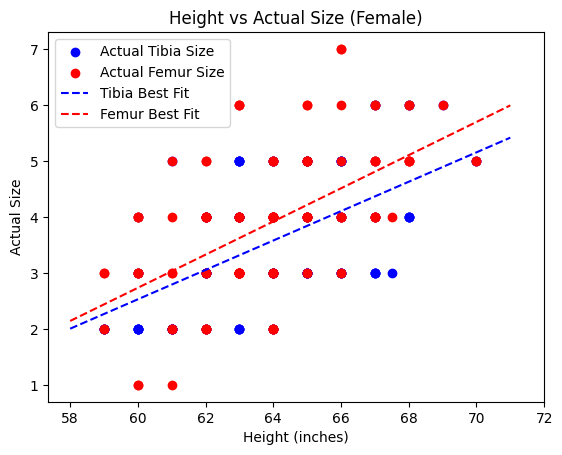

Text(value='output.pdf', description='File name:')

Button(description='Save', style=ButtonStyle())

PDF saved as output.pdf


/content/output.pdf

PDF saved as output.pdf


/content/output.pdf

Models are not trained yet.


In [ ]:
# Install required libraries
!pip install pandas numpy xgboost scikit-learn imbalanced-learn bayesian-optimization matplotlib scipy shap requests
!pip install pdfkit
!apt-get install wkhtmltopdf
!pip install reportlab

# Import required libraries for PDF creation
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import pdfkit
from IPython.display import FileLink, display

# Import other required libraries
import warnings
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import RandomOverSampler
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_rel, wilcoxon, kurtosis
from scipy.interpolate import make_interp_spline
import requests
from io import StringIO
import shap
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", message=".*test scores are non-finite.*", category=UserWarning, module='sklearn.model_selection._search')
warnings.filterwarnings("ignore", message="ARRAY API.*", category=UserWarning)
# Dictionary for femur sizes
femur_sizes = {
    1: (55.6, 59),
    2: (58.3, 62),
    3: (60.8, 65),
    4: (63.8, 68),
    5: (66.4, 71),
    6: (69.3, 74),
    7: (72.2, 77),
    8: (75.3, 80),
    9: (78.3, 83)
}
def load_data_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    data = pd.read_csv(StringIO(response.text))
    data.columns = data.columns.str.strip()
    data['age_height_interaction'] = data['age'] * data['height']
    data['height_log'] = np.log1p(data['height'])
    return data

def train_and_scale_models(data, features):
    def bayesian_optimization_xgb(X, y):
        def xgb_evaluate(n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda):
            model = XGBRegressor(
                n_estimators=int(n_estimators),
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                random_state=1
            )
            model.fit(X, y)
            return -mean_squared_error(y, model.predict(X))

        xgb_bo = BayesianOptimization(
            f=xgb_evaluate,
            pbounds={
                'n_estimators': (50, 200),
                'max_depth': (3, 7),
                'learning_rate': (0.01, 0.2),
                'reg_alpha': (0, 1),
                'reg_lambda': (0, 1)
            },
            random_state=1
        )
        xgb_bo.maximize(init_points=3, n_iter=10)  # Reduced iterations for initial testing
        return xgb_bo.max['params']

    def bayesian_optimization_gbr(X, y):
        def gbr_evaluate(n_estimators, max_depth, learning_rate, alpha):
            model = GradientBoostingRegressor(
                n_estimators=int(n_estimators),
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                alpha=alpha,
                random_state=1
            )
            model.fit(X, y)
            return -mean_squared_error(y, model.predict(X))

        gbr_bo = BayesianOptimization(
            f=gbr_evaluate,
            pbounds={
                'n_estimators': (50, 200),
                'max_depth': (3, 7),
                'learning_rate': (0.01, 0.2),
                'alpha': (1e-6, 0.99)
            },
            random_state=1
        )
        gbr_bo.maximize(init_points=3, n_iter=10)  # Reduced iterations for initial testing
        return gbr_bo.max['params']

    print("Training models...")
    X = data[features].values
    y_tibia = data['tibia used'].values
    y_femur = data['femur used'].values

    scaler_tibia = StandardScaler().fit(X)
    X_scaled_tibia = scaler_tibia.transform(X)
    scaler_femur = StandardScaler().fit(X)
    X_scaled_femur = scaler_femur.transform(X)

    xgb_params_tibia = bayesian_optimization_xgb(X_scaled_tibia, y_tibia)
    gbr_params_tibia = bayesian_optimization_gbr(X_scaled_tibia, y_tibia)
    xgb_params_femur = bayesian_optimization_xgb(X_scaled_femur, y_femur)
    gbr_params_femur = bayesian_optimization_gbr(X_scaled_femur, y_femur)

    xgb_params_tibia['n_estimators'] = int(xgb_params_tibia['n_estimators'])
    xgb_params_tibia['max_depth'] = int(xgb_params_tibia['max_depth'])
    gbr_params_tibia['n_estimators'] = int(gbr_params_tibia['n_estimators'])
    gbr_params_tibia['max_depth'] = int(gbr_params_tibia['max_depth'])
    xgb_params_femur['n_estimators'] = int(xgb_params_femur['n_estimators'])
    xgb_params_femur['max_depth'] = int(xgb_params_femur['max_depth'])
    gbr_params_femur['n_estimators'] = int(gbr_params_femur['n_estimators'])
    gbr_params_femur['max_depth'] = int(gbr_params_femur['max_depth'])

    tibia_xgb = XGBRegressor(**xgb_params_tibia, random_state=1)
    tibia_gbr = GradientBoostingRegressor(**gbr_params_tibia, random_state=1)
    femur_xgb = XGBRegressor(**xgb_params_femur, random_state=1)
    femur_gbr = GradientBoostingRegressor(**gbr_params_femur, random_state=1)

    tibia_stack = StackingRegressor(estimators=[('xgb', tibia_xgb), ('gbr', tibia_gbr)], final_estimator=XGBRegressor(), cv=5)
    femur_stack = StackingRegressor(estimators=[('xgb', femur_xgb), ('gbr', femur_gbr)], final_estimator=XGBRegressor(), cv=5)

    tibia_xgb.fit(X_scaled_tibia, y_tibia)
    tibia_gbr.fit(X_scaled_tibia, y_tibia)
    tibia_stack.fit(X_scaled_tibia, y_tibia)

    femur_xgb.fit(X_scaled_femur, y_femur)
    femur_gbr.fit(X_scaled_femur, y_femur)
    femur_stack.fit(X_scaled_femur, y_femur)

    return {
        'tibia': {'xgb': tibia_xgb, 'gbr': tibia_gbr, 'stack': tibia_stack, 'scaler': scaler_tibia},
        'femur': {'xgb': femur_xgb, 'gbr': femur_gbr, 'stack': femur_stack, 'scaler': scaler_femur}
    }

class TibiaFemurPredictor:
    def __init__(self):
        self.models = None
        self.data = None

    def oversample_minority_group(self, data):
        if 0 in data['sex'].values and 1 in data['sex'].values:
            X = data.drop('sex', axis=1)
            y = data['sex']
            ros = RandomOverSampler(random_state=1)
            X_resampled, y_resampled = ros.fit_resample(X, y)
            return pd.concat([X_resampled, y_resampled], axis=1)
        else:
            print("Both male and female samples are required for oversampling.")
            return data

    def train_models(self):
        self.data = self.oversample_minority_group(self.data)
        self.models = train_and_scale_models(self.data, ['height_log', 'age_height_interaction', 'sex'])
        print("Models trained and scalers initialized.")

    def plot_learning_curve(self, estimator, title, X, y, ax, color):
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        ax.plot(train_sizes, train_scores_mean, 'o-', color=color, label=f"Training score {title}")
        ax.plot(train_sizes, test_scores_mean, 'o-', color=color, label=f"Cross-validation score {title}")
        ax.set_title(title)
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.legend(loc="best")
        ax.grid()

    def plot_superimposed_learning_curves(self):
        X = self.data[['height_log', 'age_height_interaction', 'sex']].values
        y_tibia = self.data['tibia used'].values
        y_femur = self.data['femur used'].values

        fig, axes = plt.subplots(3, 2, figsize=(10, 5))
        self.plot_learning_curve(self.models['tibia']['xgb'], "Tibia XGB", X, y_tibia, axes[0, 0], 'blue')
        self.plot_learning_curve(self.models['tibia']['gbr'], "Tibia GBR", X, y_tibia, axes[0, 1], 'red')
        self.plot_learning_curve(self.models['tibia']['stack'], "Tibia Stack", X, y_tibia, axes[1, 0], 'purple')
        self.plot_learning_curve(self.models['femur']['xgb'], "Femur XGB", X, y_femur, axes[1, 1], 'blue')
        self.plot_learning_curve(self.models['femur']['gbr'], "Femur GBR", X, y_femur, axes[2, 0], 'red')
        self.plot_learning_curve(self.models['femur']['stack'], "Femur Stack", X, y_femur, axes[2, 1], 'purple')

        plt.show()

    def plot_qq_plots(self):
        features = ['height_log', 'age_height_interaction', 'sex']
        X_tibia = self.data[features].values
        y_tibia = self.data['tibia used'].values
        X_femur = self.data[features].values
        y_femur = self.data['femur used'].values

        X_tibia_scaled = self.models['tibia']['scaler'].transform(X_tibia)
        X_femur_scaled = self.models['femur']['scaler'].transform(X_femur)

        residuals = {
            'tibia_xgb': y_tibia - self.models['tibia']['xgb'].predict(X_tibia_scaled),
            'tibia_gbr': y_tibia - self.models['tibia']['gbr'].predict(X_tibia_scaled),
            'tibia_stack': y_tibia - self.models['tibia']['stack'].predict(X_tibia_scaled),
            'femur_xgb': y_femur - self.models['femur']['xgb'].predict(X_femur_scaled),
            'femur_gbr': y_femur - self.models['femur']['gbr'].predict(X_femur_scaled),
            'femur_stack': y_femur - self.models['femur']['stack'].predict(X_femur_scaled),
        }

        fig, axes = plt.subplots(3, 2, figsize=(15, 8))
        fig.suptitle('QQ Plots for Residuals')

        for i, (key, res) in enumerate(residuals.items()):
            ax = axes[i // 2, i % 2]
            stats.probplot(res, dist="norm", plot=ax)
            ax.set_title(key.replace('_', ' ').title())

        plt.show()

    def evaluate_models(self):
        features = ['height_log', 'age_height_interaction', 'sex']
        X_tibia = self.data[features].values
        y_tibia = self.data['tibia used'].values
        X_femur = self.data[features].values
        y_femur = self.data['femur used'].values

        X_tibia_scaled = self.models['tibia']['scaler'].transform(X_tibia)
        X_femur_scaled = self.models['femur']['scaler'].transform(X_femur)

        tibia_metrics = self.calculate_metrics(X_tibia_scaled, y_tibia, 'tibia')
        femur_metrics = self.calculate_metrics(X_femur_scaled, y_femur, 'femur')

        self.display_interactive_table(tibia_metrics, femur_metrics)

    def calculate_metrics(self, X, y, bone):
        model_types = ['xgb', 'gbr', 'stack']
        metrics = {}

        for model_type in model_types:
            model = self.models[bone][model_type]
            preds = model.predict(X)
            residuals = y - preds

            metrics[model_type] = {
                'r2_score': r2_score(y, preds),
                'rmse': mean_squared_error(y, preds, squared=False),
                'mse': mean_squared_error(y, preds),
                'mae': mean_absolute_error(y, preds),
                'mape': np.mean(np.abs((y - preds) / y)) * 100,
                'kurtosis': kurtosis(residuals)
            }

        return metrics

    def display_interactive_table(self, tibia_metrics, femur_metrics):
        metrics_data = {
            'Metric': ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis'],
            'Tibia XGB': [tibia_metrics['xgb'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']],
            'Tibia GBR': [tibia_metrics['gbr'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']],
            'Tibia Stack': [tibia_metrics['stack'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']],
            'Femur XGB': [femur_metrics['xgb'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']],
            'Femur GBR': [femur_metrics['gbr'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']],
            'Femur Stack': [femur_metrics['stack'][key] for key in ['r2_score', 'rmse', 'mse', 'mae', 'mape', 'kurtosis']]
        }

        df_metrics = pd.DataFrame(metrics_data)
        display(df_metrics)

    def calculate_residual_tests(self):
        features = ['height_log', 'age_height_interaction', 'sex']
        X_tibia = self.data[features].values
        y_tibia = self.data['tibia used'].values
        X_femur = self.data[features].values
        y_femur = self.data['femur used'].values

        X_tibia_scaled = self.models['tibia']['scaler'].transform(X_tibia)
        X_femur_scaled = self.models['femur']['scaler'].transform(X_femur)

        residuals = {
            'tibia_xgb': y_tibia - self.models['tibia']['xgb'].predict(X_tibia_scaled),
            'tibia_gbr': y_tibia - self.models['tibia']['gbr'].predict(X_tibia_scaled),
            'tibia_stack': y_tibia - self.models['tibia']['stack'].predict(X_tibia_scaled),
            'femur_xgb': y_femur - self.models['femur']['xgb'].predict(X_femur_scaled),
            'femur_gbr': y_femur - self.models['femur']['gbr'].predict(X_femur_scaled),
            'femur_stack': y_femur - self.models['femur']['stack'].predict(X_femur_scaled),
        }

        residual_tests_data = {
            'Model': [],
            'T-score': [],
            'P-value': [],
            'Wilcoxon P-value': []
        }

        model_pairs = [
            ('tibia_xgb', 'tibia_gbr'),
            ('tibia_xgb', 'tibia_stack'),
            ('tibia_gbr', 'tibia_stack'),
            ('femur_xgb', 'femur_gbr'),
            ('femur_xgb', 'femur_stack'),
            ('femur_gbr', 'femur_stack')
        ]

        for (model1, model2) in model_pairs:
            t_score, p_value = ttest_rel(residuals[model1], residuals[model2])
            _, wilcoxon_p_value = wilcoxon(residuals[model1], residuals[model2])

            residual_tests_data['Model'].append(f'{model1} vs {model2}')
            residual_tests_data['T-score'].append(round(t_score, 4))
            residual_tests_data['P-value'].append(round(p_value, 4))
            residual_tests_data['Wilcoxon P-value'].append(round(wilcoxon_p_value, 4))

        df_residual_tests = pd.DataFrame(residual_tests_data)
        display(df_residual_tests)

    def plot_height_vs_predicted_size(self, sex_val, age):
        if sex_val == 0:  # Female
            heights = np.linspace(58, 72, 100)
        else:  # Male
            heights = np.linspace(65, 76, 100)

        tibia_pred_xgb = []
        tibia_pred_gbr = []
        tibia_pred_stack = []
        femur_pred_xgb = []
        femur_pred_gbr = []
        femur_pred_stack = []

        for height in heights:
            X_new = np.array([[np.log1p(height), age * height, sex_val]])
            X_new_scaled_tibia = self.models['tibia']['scaler'].transform(X_new)
            X_new_scaled_femur = self.models['femur']['scaler'].transform(X_new)

            tibia_pred_xgb.append(self.models['tibia']['xgb'].predict(X_new_scaled_tibia)[0])
            tibia_pred_gbr.append(self.models['tibia']['gbr'].predict(X_new_scaled_tibia)[0])
            tibia_pred_stack.append(self.models['tibia']['stack'].predict(X_new_scaled_tibia)[0])
            femur_pred_xgb.append(self.models['femur']['xgb'].predict(X_new_scaled_femur)[0])
            femur_pred_gbr.append(self.models['femur']['gbr'].predict(X_new_scaled_femur)[0])
            femur_pred_stack.append(self.models['femur']['stack'].predict(X_new_scaled_femur)[0])

        fig, ax = plt.subplots()

        show_tibia_xgb = True
        show_tibia_gbr = True
        show_tibia_stack = True
        show_femur_xgb = True
        show_femur_gbr = True
        show_femur_stack = True
        smooth = 'None'
        best_fit = True

        if smooth == 'Spline Interpolation':
            heights_smooth = np.linspace(heights.min(), heights.max(), 300)
            if show_tibia_xgb:
                tibia_smooth = make_interp_spline(heights, tibia_pred_xgb)(heights_smooth)
                ax.plot(heights_smooth, tibia_smooth, color='blue', label='Tibia XGB')
            if show_tibia_gbr:
                tibia_smooth = make_interp_spline(heights, tibia_pred_gbr)(heights_smooth)
                ax.plot(heights_smooth, tibia_smooth, color='green', label='Tibia GBR')
            if show_tibia_stack:
                tibia_smooth = make_interp_spline(heights, tibia_pred_stack)(heights_smooth)
                ax.plot(heights_smooth, tibia_smooth, color='purple', label='Tibia Stack')
            if show_femur_xgb:
                femur_smooth = make_interp_spline(heights, femur_pred_xgb)(heights_smooth)
                ax.plot(heights_smooth, femur_smooth, color='red', label='Femur XGB')
            if show_femur_gbr:
                femur_smooth = make_interp_spline(heights, femur_pred_gbr)(heights_smooth)
                ax.plot(heights_smooth, femur_smooth, color='lime', label='Femur GBR')
            if show_femur_stack:
                femur_smooth = make_interp_spline(heights, femur_pred_stack)(heights_smooth)
                ax.plot(heights_smooth, femur_smooth, color='brown', label='Femur Stack')
        elif smooth == 'Moving Average':
            window_size = 5
            if show_tibia_xgb:
                tibia_ma = np.convolve(tibia_pred_xgb, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(tibia_ma)], tibia_ma, color='blue', label='Tibia XGB')
            if show_tibia_gbr:
                tibia_ma = np.convolve(tibia_pred_gbr, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(tibia_ma)], tibia_ma, color='green', label='Tibia GBR')
            if show_tibia_stack:
                tibia_ma = np.convolve(tibia_pred_stack, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(tibia_ma)], tibia_ma, color='purple', label='Tibia Stack')
            if show_femur_xgb:
                femur_ma = np.convolve(femur_pred_xgb, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(femur_ma)], femur_ma, color='red', label='Femur XGB')
            if show_femur_gbr:
                femur_ma = np.convolve(femur_pred_gbr, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(femur_ma)], femur_ma, color='lime', label='Femur GBR')
            if show_femur_stack:
                femur_ma = np.convolve(femur_pred_stack, np.ones(window_size)/window_size, mode='valid')
                ax.plot(heights[:len(femur_ma)], femur_ma, color='brown', label='Femur Stack')
        else:
            if show_tibia_xgb:
                ax.plot(heights, tibia_pred_xgb, color='blue', label='Tibia XGB')
            if show_tibia_gbr:
                ax.plot(heights, tibia_pred_gbr, color='green', label='Tibia GBR')
            if show_tibia_stack:
                ax.plot(heights, tibia_pred_stack, color='purple', label='Tibia Stack')
            if show_femur_xgb:
                ax.plot(heights, femur_pred_xgb, color='red', label='Femur XGB')
            if show_femur_gbr:
                ax.plot(heights, femur_pred_gbr, color='lime', label='Femur GBR')
            if show_femur_stack:
                ax.plot(heights, femur_pred_stack, color='brown', label='Femur Stack')

        if best_fit:
            if show_tibia_xgb:
                coeffs = np.polyfit(heights, tibia_pred_xgb, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_tibia_xgb:
                    ax.plot(heights, best_fit_line, color='blue', linestyle='--', label='Tibia XGB Best Fit')
                mae = mean_absolute_error(tibia_pred_xgb, best_fit_line)
                print(f"Tibia XGB MAE: {mae:.4f}")
            if show_tibia_gbr:
                coeffs = np.polyfit(heights, tibia_pred_gbr, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_tibia_gbr:
                    ax.plot(heights, best_fit_line, color='green', linestyle='--', label='Tibia GBR Best Fit')
                mae = mean_absolute_error(tibia_pred_gbr, best_fit_line)
                print(f"Tibia GBR MAE: {mae:.4f}")
            if show_tibia_stack:
                coeffs = np.polyfit(heights, tibia_pred_stack, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_tibia_stack:
                    ax.plot(heights, best_fit_line, color='purple', linestyle='--', label='Tibia Stack Best Fit')
                mae = mean_absolute_error(tibia_pred_stack, best_fit_line)
                print(f"Tibia Stack MAE: {mae:.4f}")
            if show_femur_xgb:
                coeffs = np.polyfit(heights, femur_pred_xgb, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_femur_xgb:
                    ax.plot(heights, best_fit_line, color='red', linestyle='--', label='Femur XGB Best Fit')
                mae = mean_absolute_error(femur_pred_xgb, best_fit_line)
                print(f"Femur XGB MAE: {mae:.4f}")
            if show_femur_gbr:
                coeffs = np.polyfit(heights, femur_pred_gbr, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_femur_gbr:
                    ax.plot(heights, best_fit_line, color='lime', linestyle='--', label='Femur GBR Best Fit')
                mae = mean_absolute_error(femur_pred_gbr, best_fit_line)
                print(f"Femur GBR MAE: {mae:.4f}")
            if show_femur_stack:
                coeffs = np.polyfit(heights, femur_pred_stack, 1)
                best_fit_line = np.polyval(coeffs, heights)
                if show_femur_stack:
                    ax.plot(heights, best_fit_line, color='brown', linestyle='--', label='Femur Stack Best Fit')
                mae = mean_absolute_error(femur_pred_stack, best_fit_line)
                print(f"Femur Stack MAE: {mae:.4f}")

        ax.set_xlabel('Height (inches)')
        ax.set_xticks(np.arange(55 if sex_val else 58, 77 if sex_val else 73, 2))  # Wider increments on x-axis
        ax.set_ylabel('Predicted Size')
        ax.set_title(f'Height vs Predicted Size ({"Female" if sex_val == 0 else "Male"})')
        ax.legend()
        plt.show()

    def plot_height_vs_actual_size(self, sex_val):
        if sex_val == 0:  # Female
            heights = np.linspace(58, 71, 100)
            data_filtered = self.data[self.data['sex'] == 0]
        else:  # Male
            heights = np.linspace(64, 76, 100)
            data_filtered = self.data[self.data['sex'] == 1]

        actual_tibia = data_filtered['tibia used'].values
        actual_femur = data_filtered['femur used'].values
        height_data = data_filtered['height'].values

        fig, ax = plt.subplots()

        show_tibia_actual = True
        show_femur_actual = True
        best_fit = True

        if show_tibia_actual:
            ax.scatter(height_data, actual_tibia, color='blue', label='Actual Tibia Size')
        if show_femur_actual:
            ax.scatter(height_data, actual_femur, color='red', label='Actual Femur Size')

        if best_fit:
            if show_tibia_actual:
                coeffs = np.polyfit(height_data, actual_tibia, 1)
                best_fit_line = np.polyval(coeffs, heights)
                ax.plot(heights, best_fit_line, color='blue', linestyle='--', label='Tibia Best Fit')
                mae = mean_absolute_error(actual_tibia, np.polyval(coeffs, height_data))
                print(f"Tibia MAE: {mae:.4f}")
            if show_femur_actual:
                coeffs = np.polyfit(height_data, actual_femur, 1)
                best_fit_line = np.polyval(coeffs, heights)
                ax.plot(heights, best_fit_line, color='red', linestyle='--', label='Femur Best Fit')
                mae = mean_absolute_error(actual_femur, np.polyval(coeffs, height_data))
                print(f"Femur MAE: {mae:.4f}")

        ax.set_xlabel('Height (inches)')
        ax.set_xticks(np.arange(55 if sex_val else 58, 77 if sex_val else 73, 2))  # Wider increments on x-axis
        ax.set_ylabel('Actual Size')
        ax.set_title(f'Height vs Actual Size ({"Female" if sex_val == 0 else "Male"})')
        ax.legend()
        plt.show()
    def save_outputs_as_pdf(self, filename='output.pdf'):
        c = canvas.Canvas(filename, pagesize=letter)
        width, height = letter

        # Save all current plots
        plt.savefig("/tmp/current_plot.png")

        # Draw the plots on the PDF
        c.drawImage("/tmp/current_plot.png", 0, 0, width, height)
        c.showPage()
        c.save()

        print(f"PDF saved as {filename}")
        display(FileLink(filename))
    def predict(self, age, height, sex, model_type):
        if not self.models:
            print("Models are not trained yet.")
            return None, None

        X_new = np.array([[np.log1p(height), age * height, sex]])
        tibia_scaler = self.models['tibia']['scaler']
        femur_scaler = self.models['femur']['scaler']
        X_new_scaled_tibia = tibia_scaler.transform(X_new)
        X_new_scaled_femur = femur_scaler.transform(X_new)

        preds_tibia = self.models['tibia'][model_type].predict(X_new_scaled_tibia)
        preds_femur = self.models['femur'][model_type].predict(X_new_scaled_femur)

        return preds_tibia[0], preds_femur[0]

    def display_model_details(self):
        features = ['height_log', 'age_height_interaction', 'sex']
        for bone in ['tibia', 'femur']:
            print(f"### {bone.capitalize()} Models")
            for model_type in ['xgb', 'gbr', 'stack']:
                print(f"#### {model_type.upper()}")
                model_instance = self.models[bone][model_type]
                if hasattr(model_instance, 'feature_importances_'):
                    plt.figure(figsize=(5, 3))
                    plt.title(f"{model_type.upper()} Feature Importances ({bone.capitalize()})")
                    plt.bar(range(len(features)), model_instance.feature_importances_)
                    plt.xticks(range(len(features)), features, rotation=90)
                    plt.show()
                elif model_type == 'xgb':
                    fig, ax = plt.subplots(figsize=(5, 3))
                    plot_importance(model_instance, ax=ax)
                    plt.show()
                print("---")

        print("### SHAP Values")
        for bone in ['tibia', 'femur']:
            print(f"#### {bone.capitalize()}")
            model_instance = self.models[bone]['xgb']
            explainer = shap.Explainer(model_instance)
            shap_values = explainer.shap_values(self.data[features])

            shap.summary_plot(shap_values, self.data[features], plot_type="bar")
            plt.show()

            shap.summary_plot(shap_values, self.data[features])
            plt.show()

        print("### Partial Dependence Plots")
        for bone in ['tibia', 'femur']:
            print(f"#### {bone.capitalize()}")
            model_instance = self.models[bone]['xgb']
            fig, ax = plt.subplots(figsize=(5, 3))
            PartialDependenceDisplay.from_estimator(model_instance, self.data[features], features, ax=ax)
            plt.show()
    def save_outputs_as_pdf(self, filename='output.pdf'):
        # Get the notebook content
        from IPython.display import display, HTML
        from google.colab import output

        # Use HTML to save notebook content
        html = output.eval_js('document.documentElement.outerHTML')

        # Save as PDF
        pdfkit.from_string(html, filename)

        print(f"PDF saved as {filename}")
        display(FileLink(filename))
def main():
    predictor = TibiaFemurPredictor()

    # Dictionary of available CSV files and their URLs
    csv_files = {
        "Data Central Florida": "https://raw.githubusercontent.com/Msmbusiness/Knee/main/data%20central%20florida.csv",
        "Data Midwest": "https://raw.githubusercontent.com/Msmbusiness/Knee/main/data%20midwest.csv"
    }

    default_file = "Data Central Florida"
    file_selector = widgets.Dropdown(
        options=csv_files.keys(),
        value=default_file,
        description='Select CSV File:',
    )
    display(file_selector)

    file_url = csv_files[file_selector.value]
    predictor.data = load_data_from_url(file_url)
    print(f"Data file '{file_selector.value}' loaded successfully.")

    train_button = widgets.Button(description="Train Models")
    display(train_button)

    def on_train_button_clicked(b):
        predictor.train_models()

    train_button.on_click(on_train_button_clicked)

    age_slider = widgets.IntSlider(value=68, min=55, max=85, description='Age:')
    height_slider = widgets.IntSlider(value=68, min=60, max=76, description='Height:')
    sex_selector = widgets.RadioButtons(options=['Female', 'Male'], description='Sex:')
    model_selector = widgets.Dropdown(options=['xgb', 'gbr', 'stack'], value='xgb', description='Model:')
    display(age_slider, height_slider, sex_selector, model_selector)

    predict_button = widgets.Button(description="Predict")
    display(predict_button)

    def on_predict_button_clicked(b):
        sex_val = 0 if sex_selector.value == 'Female' else 1
        tibia_pred, femur_pred = predictor.predict(age_slider.value, height_slider.value, sex_val, model_selector.value)
        if tibia_pred is not None and femur_pred is not None:
            print(f"Tibia Prediction: {tibia_pred:.2f}")
            print(f"Femur Prediction: {femur_pred:.2f}")

    predict_button.on_click(on_predict_button_clicked)

    plot_superimposed_button = widgets.Button(description="Plot Superimposed Learning Curves")
    display(plot_superimposed_button)

    def on_plot_superimposed_button_clicked(b):
        predictor.plot_superimposed_learning_curves()

    plot_superimposed_button.on_click(on_plot_superimposed_button_clicked)

    qq_plot_button = widgets.Button(description="Plot QQ Plots for Residuals")
    display(qq_plot_button)

    def on_qq_plot_button_clicked(b):
        predictor.plot_qq_plots()

    qq_plot_button.on_click(on_qq_plot_button_clicked)

    evaluate_button = widgets.Button(description="Evaluate Models")
    display(evaluate_button)

    def on_evaluate_button_clicked(b):
        predictor.evaluate_models()

    evaluate_button.on_click(on_evaluate_button_clicked)

    residual_test_button = widgets.Button(description="Calculate Residual Tests")
    display(residual_test_button)

    def on_residual_test_button_clicked(b):
        predictor.calculate_residual_tests()

    residual_test_button.on_click(on_residual_test_button_clicked)

    model_details_button = widgets.Button(description="Display Model Details")
    display(model_details_button)

    def on_model_details_button_clicked(b):
        predictor.display_model_details()

    model_details_button.on_click(on_model_details_button_clicked)

    plot_predicted_button = widgets.Button(description="Plot Height vs Predicted Size")
    display(plot_predicted_button)

    def on_plot_predicted_button_clicked(b):
        sex_val = 0 if sex_selector.value == 'Female' else 1
        predictor.plot_height_vs_predicted_size(sex_val, age_slider.value)

    plot_predicted_button.on_click(on_plot_predicted_button_clicked)

    plot_actual_button = widgets.Button(description="Plot Height vs Actual Size")
    display(plot_actual_button)

    def on_plot_actual_button_clicked(b):
        sex_val = 0 if sex_selector.value == 'Female' else 1
        predictor.plot_height_vs_actual_size(sex_val)

    plot_actual_button.on_click(on_plot_actual_button_clicked)
    save_button = widgets.Button(description="Save as PDF")
    display(save_button)

    def on_save_button_clicked(b):
        filename_widget = widgets.Text(description='File name:', value='output.pdf')
        display(filename_widget)
        save_button_confirm = widgets.Button(description="Save")
        display(save_button_confirm)

        def on_save_button_confirm_clicked(b):
            predictor.save_outputs_as_pdf(filename_widget.value)

        save_button_confirm.on_click(on_save_button_confirm_clicked)

    save_button.on_click(on_save_button_clicked)

if __name__ == "__main__":
    main()